# compute volume census for CESM solution

In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le
plot_grid_vars = ['TLAT','TLONG','KMT','TAREA','ULAT','ULONG','UAREA',
                  'z_t','z_t_150m','z_w','dz',
                  'area_sum','vol_sum','year','lat_t','lat_t_edges']

In [2]:
%%time
v = 'O2'
op = 'ann_dft'
file_in = os.path.join(diro['work'],'tr85.avg.%s.%s.1920-2100.nc'%(op,v))
print file_in
tr85a = xr.open_dataset(file_in,decode_times=False,decode_coords=False)

file_in = os.path.join(diro['work'],'tr45.avg.%s.%s.1920-2100.nc'%(op,v))
tr45a = xr.open_dataset(file_in,decode_times=False,decode_coords=False)
tr85a = tr85a.drop([k for k in tr85a if k not in plot_grid_vars and k != v])
tr45a = tr45a.drop([k for k in tr45a if k not in plot_grid_vars and k != v])
print tr85a

/glade/scratch/mclong/calcs/iucn-ch/work/tr85.avg.ann_dft.O2.1920-2100.nc
<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 181, z_t: 60, z_t_150m: 15, z_w: 60)
Coordinates:
  * z_t       (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
  * z_w       (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
Dimensions without coordinates: nlat, nlon, time
Data variables:
    O2        (time, z_t, nlat, nlon) float32 nan nan nan nan nan nan nan ...
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 1.124e+13 ...
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 -79.22 ...
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 327.3 ...
    UAREA     (nlat, nlon) float64 1.423e+13 1.423e+13 1.423e+13 1.423e+13 ...
    ULAT      (nlat, nlon) float64 -78.9

In [3]:
%%time
baseline = tr85a.isel(time=slice(0,20)).mean(dim='time')
print baseline

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15, z_w: 60)
Coordinates:
  * z_t       (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
  * z_w       (z_w) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    O2        (z_t, nlat, nlon) float32 nan nan nan nan nan nan nan nan nan ...
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 1.124e+13 1.124e+13 ...
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 -79.22 ...
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 327.3 ...
    UAREA     (nlat, nlon) float64 1.423e+13 1.423e+13 1.423e+13 1.423e+13 ...
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 -78.95 -78.95 -78.95 ...
    ULONG     (nlat, nlon) float64 321.1 322.3 3

### compute region mask

In [4]:
mask_file_in = '/glade/p/work/mclong/grids/PacAtlInd_REGION_MASK_gx1v6.nc'
dsm = xr.open_dataset(mask_file_in,decode_coords=False)
region = dsm.REGION_MASK.where(dsm.REGION_MASK!=0).pipe(np.unique)
region = region[~np.isnan(region)]
nrgn = len(region)+1
mask3d = xr.DataArray(np.zeros((nrgn,)+dsm.REGION_MASK.shape),
                      dims=('region','nlat','nlon'))
mask3d.values[0,:,:] = np.where(dsm.REGION_MASK>0,1,0)
for i,r in enumerate(region):
    mask3d.values[i+1,:,:] = np.where(dsm.REGION_MASK==r,1,0)
print mask3d

<xarray.DataArray (region: 4, nlat: 384, nlon: 320)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Dimensions without coordinates: region, nlat, nlon


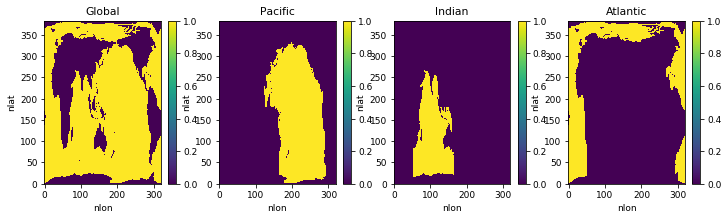

In [5]:
region_names = ['Global', 'Pacific', 'Indian', 'Atlantic']
fig = plt.figure(figsize=(12,3)); 
gs = gridspec.GridSpec(1,4)
ax = [fig.add_subplot(gs[0,i]) for i in range(4)]
for i in range(4):
    mask3d[i,:,:].plot(ax=ax[i]);
    ax[i].set_title(region_names[i])

compute grid volume array

In [6]:
%%time
reload(et)
vol = et.pop_ocean_volume(tr85a)
tr85a['vol'] = vol
tr45a['vol'] = vol
baseline['vol'] = vol
print vol

<xarray.DataArray (z_t: 60, nlat: 384, nlon: 320)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
Dimensions without coordinates: nlat, nlon
CPU times: user 15.1 s, sys: 7 ms, total: 15.1 s
Wall time: 15.1 s


In [7]:
print tr85a.time
np.arange(1920,2101,1)[-21]

<xarray.DataArray 'time' (time: 181)>
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 1

2080

In [10]:
%%time
do2 = 1.
o2_bins = np.arange(0.,360.+do2,do2)

o2_binc = np.vstack((o2_bins[:-1],o2_bins[1:])).mean(axis=0)
o2_binc

dss = [('Control',baseline),
       ('2100 (RCP8.5)',tr85a.sel(time=-1)),
       ('2080 (RCP8.5)',tr85a.sel(time=-21)),
       ('2080 (RCP4.5)',tr45a.sel(time=-1))]

vol_by_o2 = {}
for i,rname in enumerate(region_names):
    for j,(dsname,ds) in enumerate(dss):
        x = ds.groupby_bins('O2',o2_bins).sum()        
        vol_by_o2[rname+'_'+dsname] = x.vol
        if j > 0:
            vol_by_o2[rname+'_'+dsname] = vol_by_o2[rname+'_'+dsname] - \
                                          vol_by_o2[rname+'_Control']
        
dss = dss[1:]
print vol_by_o2['Global_2100 (RCP8.5)']

<xarray.DataArray 'vol' (O2_bins: 360)>
array([  5.661486e+19,   2.309853e+18,  -4.494502e+17, ...,  -3.446590e+18,
        -2.788083e+18,  -4.128830e+18])
Coordinates:
  * O2_bins  (O2_bins) object '(0, 1]' '(1, 2]' '(2, 3]' '(3, 4]' '(4, 5]' ...
CPU times: user 2min 14s, sys: 6.9 s, total: 2min 21s
Wall time: 2min 22s


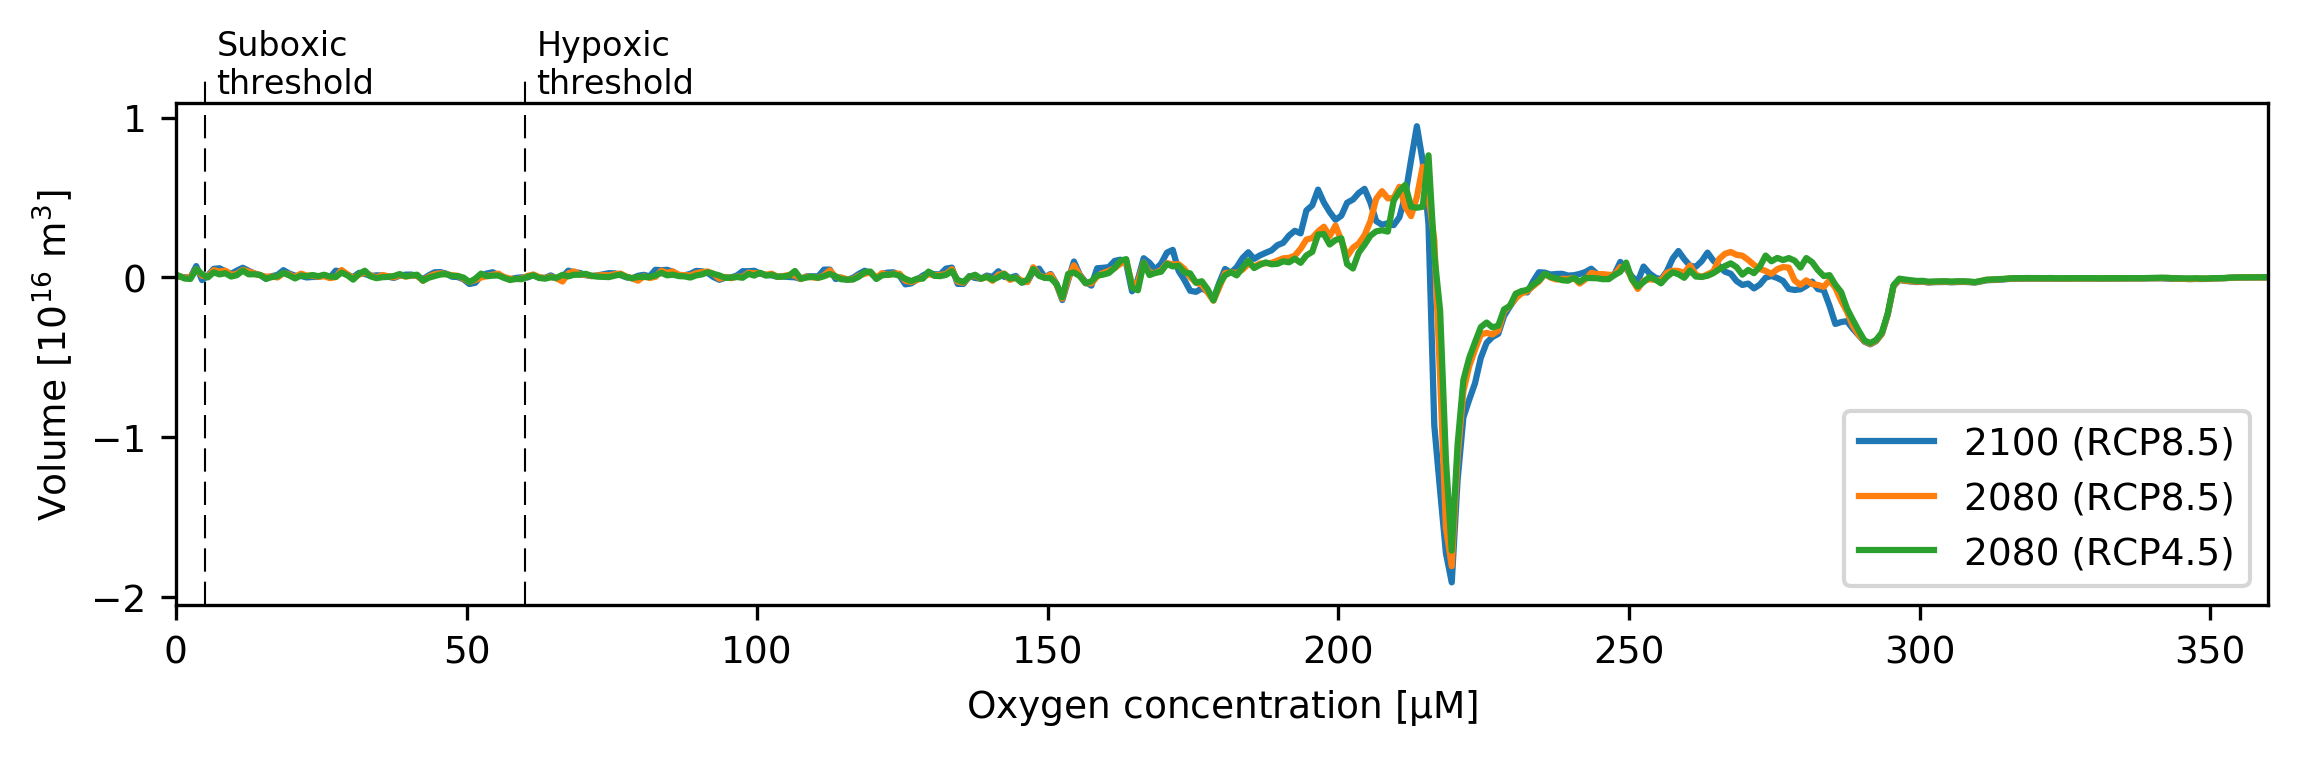

In [13]:
plot_name = os.path.join(diro['fig'],'cesm_o2pdfs.pdf')

fig = plt.figure(dpi=300,figsize=(9,7),facecolor='w')
gs = gridspec.GridSpec(3,1)

hypoxia = 60.
suboxia = 5.

#----------------------------------------------------------------------
#-- plot o2 pdf
#----------------------------------------------------------------------
ax = fig.add_subplot(gs[0,0])
for rname in ['Global']:
    for j,(dsname,ds) in enumerate(dss):
        ax.plot(o2_binc,vol_by_o2[rname+'_'+dsname]*1e-16*1e-6,label=dsname)

ax.set_ylabel('Volume [10$^{16}$ m$^3$]')
ax.set_xlabel('Oxygen concentration [$\mu$M]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.set_xticklabels([])
ax.set_xlim((o2_bins[0],o2_bins[-1]))
ylm = ax.get_ylim()

ax.axvline(x=hypoxia,ymax=1.06,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)
ax.axvline(x=suboxia,ymax=1.05,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)

ax.text(hypoxia+2,ylm[1]+0.02*np.diff(ylm), 'Hypoxic\nthreshold',fontsize=8)
ax.text(suboxia+2,ylm[1]+0.02*np.diff(ylm), 'Suboxic\nthreshold',fontsize=8)

gs.update(hspace=0.08)  

ax = fig.get_axes()

#alp = [chr(i).upper() for i in range(97,97+26)]
#for i,axi in enumerate(ax):
#    p = axi.get_position()
#    y = p.y1-0.02
#    fig.text(0.03,y,'%s'%alp[i],
#             fontsize=14.,
#             fontweight = 'semibold')

plt.savefig(plot_name,bbox_inches='tight')